https://colab.research.google.com/drive/1dWEi4V0ULEYzfQsGAlGuMPueCCe_xw3H#scrollTo=ZEMGqqKsaQN8

# Предобработка данных

In [1]:
import numpy as np

import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

from keras.layers import Dense, Conv2D, MaxPooling2D, InputLayer, Flatten
from keras.models import Model, Sequential

import random

Скачиваем данные

Подключение диска

В папке <code>/content/drive/MyDrive/Colab Notebooks/data/</code> должен лежать файл

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Распаковка данных из архива

In [3]:
!unzip '/content/drive/MyDrive/Colab Notebooks/data/Dog_cats.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/data/Dog_cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


Отключаем гугл диск

In [4]:
drive.flush_and_unmount()

Убираем ненужный файл

In [5]:
!rm -rf sample_data
!rm -rf sampleSubmission.csv
!rm -rf train
!rm -rf test1
!rm test1.zip

Распаковка файлов

флаг -q означает скрыть вывод

In [6]:
!unzip -q 'train.zip'

Удалим архивы

In [7]:
!rm train.zip
!ls

train


Создадим подпапки - <code>cat</code>, <code>dog</code>.

In [8]:
import os
root = 'train'
os.mkdir('train/cat')
os.mkdir('train/dog')

Переместим изображения по соответствующим папкам

Будем брать только первые 1000 изображений (иначе переполнение памяти диска)

In [9]:
root = 'train'
old_path = 'train/'
new_path_cat = 'train/cat/'
new_path_dog = 'train/dog/'
max_img = 1000
cat_img = 0
dog_img = 0
for x in os.walk(root):
  file_names = x[2]
  for name in file_names:
    if name.find('cat') != -1:
      if cat_img < max_img:
        os.replace(old_path + name, new_path_cat + name[4:])
        cat_img += 1
    elif name.find('dog') != -1:
      if dog_img < max_img:
        os.replace(old_path + name, new_path_dog + name[4:])
        dog_img += 1

In [10]:
del old_path
del new_path_cat
del new_path_dog
del max_img
del cat_img
del dog_img
del file_names

Получим категории

In [11]:
root = 'train'
categories = [x[0] for x in os.walk(root) if x[0]][1:]
del root
categories

['train/cat', 'train/dog']

Функция <code>get_image</code> получает изображение по пути <code>path</code> и преобразует его в список

In [12]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x  

По каждой из выбранных категорий получаем список изображений 


```
{
  'x': np.array(x[0]),
  'y': c
}
```

где <code>x</code> - изображение в виде списка, <code>c</code> - метка класса



In [13]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Разделяем данные на тренировку и тест

In [14]:
random.shuffle(data)
train_split = 0.8
idx_test = int((train_split) * len(data))

data_train = data[:idx_test]
data_test = data[idx_test:]
del data

Формирование целевого признака и выборки на основе данных

In [15]:
x_train, y_train = np.array([t["x"] for t in data_train]), [t["y"] for t in data_train]
x_test, y_test = np.array([t["x"] for t in data_test]), [t["y"] for t in data_test]
del data_train
del data_test

Нормализуем данные x [0, 256) -> [0, 1\]

In [16]:
x_train = x_train.astype('float') / 255.0
x_test = x_test.astype('float') / 255.0

Применяем One-hot кодирование

In [17]:
# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_train[:5]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

# Работа с моделью

# Classification

Создадим классификатор для классификации изображений. Будем использовать сверточную сеть.

Как работает свёртка:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/2D_Convolution_Animation.gif/330px-2D_Convolution_Animation.gif)

Max Pool 2d:

![](https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png)

In [18]:
print(x_train.shape, y_train.shape)
print(x_train.shape[1:])

(1600, 224, 224, 3) (1600, 2)
(224, 224, 3)


In [19]:
model = Sequential()
# Add input layer
model.add(InputLayer(input_shape=x_train.shape[1:]))
# Add two Conv2D layers
model.add(Conv2D(20, kernel_size=3))
model.add(Conv2D(20, kernel_size=3))
# Add max pooling layer
model.add(MaxPooling2D(pool_size=(10, 10)))
# Flatten layers
model.add(Flatten())
# Add RELU layers
model.add(Dense(400, activation='relu'))
model.add(Dense(100, activation='relu'))
# Add output layer
model.add(Dense(num_classes, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 20)      560       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 20)      3620      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 20)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9680)              0         
_________________________________________________________________
dense (Dense)                (None, 400)               3872400   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               40100     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2

Обучим данную модель

In [20]:
model.fit(x_train, y_train, batch_size=10, epochs=10)

Epoch 1/10
160/160 [==============================] - 34s 13ms/step - loss: 0.7139 - accuracy: 0.5647
Epoch 2/10
160/160 [==============================] - 2s 13ms/step - loss: 0.6061 - accuracy: 0.6697
Epoch 3/10
160/160 [==============================] - 2s 13ms/step - loss: 0.5354 - accuracy: 0.7245
Epoch 4/10
160/160 [==============================] - 2s 13ms/step - loss: 0.4216 - accuracy: 0.7936
Epoch 5/10
160/160 [==============================] - 2s 13ms/step - loss: 0.3052 - accuracy: 0.8716
Epoch 6/10
160/160 [==============================] - 2s 13ms/step - loss: 0.1576 - accuracy: 0.9458
Epoch 7/10
160/160 [==============================] - 2s 13ms/step - loss: 0.1252 - accuracy: 0.9463
Epoch 8/10
160/160 [==============================] - 2s 13ms/step - loss: 0.1036 - accuracy: 0.9664
Epoch 9/10
160/160 [==============================] - 2s 13ms/step - loss: 0.0472 - accuracy: 0.9832
Epoch 10/10
160/160 [==============================] - 2s 13ms/step - loss: 0.0364 - accur

подсчитаем метрики качества на тестовой выборке

In [21]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)
del loss
del accuracy
del model

Test loss: 1.2391295433044434
Test accuracy: 0.7174999713897705


Получаем точность 71 % - неплохую точность

# Подбор гиперпараметров

Будем выполнять подбор гиперпараметров

Определим функцию, которая поможет нам в этом

In [22]:
def create_model(filters=[20, 20], pool_sizes=[(10, 10), (10, 10)], dense_size=[400, 100]):
  model = Sequential()
  # Add input layer
  model.add(InputLayer(input_shape=x_train.shape[1:]))
  # Add two Conv2D layers
  model.add(Conv2D(filters[0], kernel_size=3))
  model.add(Conv2D(filters[1], kernel_size=3))
  # Add max pooling layer
  model.add(MaxPooling2D(pool_size=pool_sizes[0]))
  # Add two Conv2D layers
  model.add(Conv2D(filters[0], kernel_size=3))
  model.add(Conv2D(filters[1], kernel_size=3))
  # Add max pooling layer
  model.add(MaxPooling2D(pool_size=pool_sizes[1]))
  # Flatten layers
  model.add(Flatten())
  # Add RELU layers
  model.add(Dense(dense_size[0], activation='relu'))
  model.add(Dense(dense_size[1], activation='relu'))
  # Add output layer
  model.add(Dense(num_classes, activation='softmax'))
  # Compile model
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

In [23]:
def hyp_selections(model):
  model.fit(x_train, y_train, batch_size=10, epochs=1)
  loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
  print('Test loss:', loss)
  print('Test accuracy:', accuracy)
  return loss, accuracy

Выполним подбор гиперпараметров

In [24]:
best_filters=[20, 20]
best_pool_size=[(10, 10), (10, 10)]
best_dense_size=[400, 100]
best_acc = 0.0
for pool_size in [(10, 10), (15, 15)]:
  model = create_model(filters=best_filters, pool_sizes=[pool_size, (10, 10)])
  loss, acc = hyp_selections(model)
  if acc > best_acc:
    best_acc = acc
    best_pool_size = [pool_size, (10, 10)]
  del model
  del acc
  del loss
print('Best ')
print('{} filters, {} pool size, {} dense size'.format(best_filters, best_pool_size, best_dense_size))
print('Best accuracy: {}'.format(best_acc))

160/160 [==============================] - 3s 13ms/step - loss: 0.6947 - accuracy: 0.5185
Test loss: 0.7258023619651794
Test accuracy: 0.5375000238418579
160/160 [==============================] - 3s 13ms/step - loss: 0.6779 - accuracy: 0.5768
Test loss: 0.6546590328216553
Test accuracy: 0.6075000166893005
Best 
[20, 20] filters, [(15, 15), (10, 10)] pool size, [400, 100] dense size
Best accuracy: 0.6075000166893005


Посчитаем точность на тестовой выборке

In [25]:
best_model = create_model(filters=best_filters, pool_sizes=best_pool_size, dense_size=best_dense_size)
best_model.fit(x_train, y_train, batch_size=10, epochs=10)
loss, accuracy = best_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/10
160/160 [==============================] - 3s 13ms/step - loss: 0.6847 - accuracy: 0.5594
Epoch 2/10
160/160 [==============================] - 2s 13ms/step - loss: 0.6510 - accuracy: 0.6191
Epoch 3/10
160/160 [==============================] - 2s 13ms/step - loss: 0.6266 - accuracy: 0.6500
Epoch 4/10
160/160 [==============================] - 2s 13ms/step - loss: 0.6107 - accuracy: 0.6586
Epoch 5/10
160/160 [==============================] - 2s 13ms/step - loss: 0.6096 - accuracy: 0.6687
Epoch 6/10
160/160 [==============================] - 2s 13ms/step - loss: 0.5833 - accuracy: 0.6947
Epoch 7/10
160/160 [==============================] - 2s 13ms/step - loss: 0.5748 - accuracy: 0.6792
Epoch 8/10
160/160 [==============================] - 2s 13ms/step - loss: 0.5648 - accuracy: 0.6983
Epoch 9/10
160/160 [==============================] - 2s 13ms/step - loss: 0.5211 - accuracy: 0.7366
Epoch 10/10
160/160 [==============================] - 2s 13ms/step - loss: 0.4750 - accura

Для своего классификатора точность 70% - неплохая

Очистим данные

In [26]:
locals().clear()
for element in dir():
    if element[0:2] != "__":
        del globals()[element]

# Сеть VGG16

Восстановим данные после очищения

In [27]:
import numpy as np

import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

from keras.layers import Dense, Conv2D, MaxPooling2D, InputLayer, Flatten
from keras.models import Model, Sequential

import random

In [28]:
import os

root = 'train'
categories = [x[0] for x in os.walk(root) if x[0]][1:]
del root

print(categories)

['train/cat', 'train/dog']


In [29]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x  

In [30]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

random.shuffle(data)
train_split = 0.8
idx_test = int((train_split) * len(data))

data_train = data[:idx_test]
data_test = data[idx_test:]
del data
x_train, y_train = np.array([t["x"] for t in data_train]), [t["y"] for t in data_train]
x_test, y_test = np.array([t["x"] for t in data_test]), [t["y"] for t in data_test]
del data_train
del data_test
x_train = x_train.astype('float') / 255.0
x_test = x_test.astype('float') / 255.0
# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_train[:5])

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


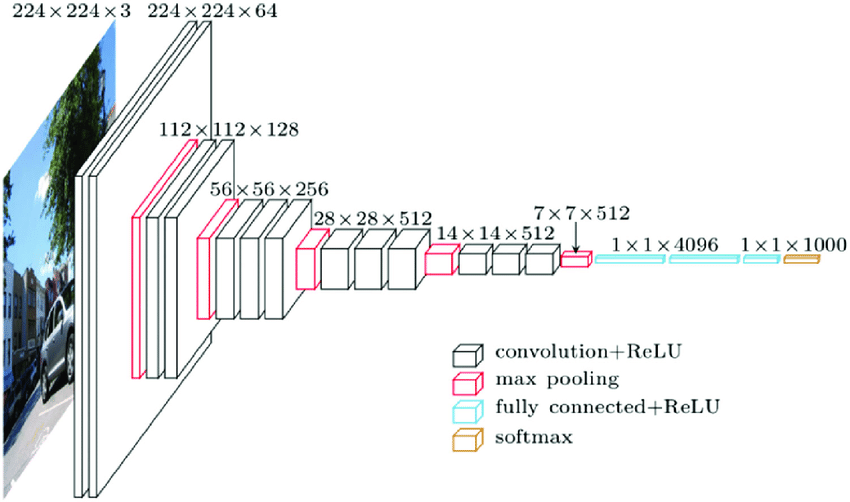

https://arxiv.org/pdf/1409.1556.pdf

Загрузка модели [VGG16](https://arxiv.org/pdf/1409.1556.pdf) по [ссылке](https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels.h5)

In [31]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467904/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

Замена последнего слоя на пользовательский, который будет уметь предсказывать ровно три класса - те, которые мы задали. Отсоединяем предыдущий последний слой и подсоединяем созданный

In [32]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

Просмотр всех слоев модели

In [33]:
model_new.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Выключаем тренировку для всех слоев кроме последнего (dense_1).

Включаем тренировку для последнего слоя.

In [34]:
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

Компилируем модель с:
- категориальной кроссэнтропией (именно для нее мы применяли one hot кодирование) Метки классов
[[1.0, 0.0],
[0.0, 0.0],...
],

- оптимизатором adam ([adaptive moments](https://vbystricky.github.io/2018/03/optimization_grad_desc.html)) - работа на основе моментов

- метрикой accuracy (точность)

In [35]:
model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Замечаем, что число параметров для тренировки равно числу параметров последнего слоя - мы отключили тренировку для остальных слоев.

## Обучение модели

In [36]:
model_new.fit(x_train, y_train, batch_size=10, epochs=10)
del x_train
del y_train

Epoch 1/10
160/160 [==============================] - 12s 56ms/step - loss: 0.5808 - accuracy: 0.6893
Epoch 2/10
160/160 [==============================] - 9s 58ms/step - loss: 0.3731 - accuracy: 0.8314
Epoch 3/10
160/160 [==============================] - 10s 61ms/step - loss: 0.2923 - accuracy: 0.8733
Epoch 4/10
160/160 [==============================] - 10s 61ms/step - loss: 0.2859 - accuracy: 0.8858
Epoch 5/10
160/160 [==============================] - 10s 61ms/step - loss: 0.2355 - accuracy: 0.8998
Epoch 6/10
160/160 [==============================] - 10s 61ms/step - loss: 0.2377 - accuracy: 0.9024
Epoch 7/10
160/160 [==============================] - 10s 61ms/step - loss: 0.2363 - accuracy: 0.9086
Epoch 8/10
160/160 [==============================] - 10s 60ms/step - loss: 0.2183 - accuracy: 0.9105
Epoch 9/10
160/160 [==============================] - 9s 59ms/step - loss: 0.1611 - accuracy: 0.9448
Epoch 10/10
160/160 [==============================] - 9s 59ms/step - loss: 0.1529 -

подсчитаем метрики качества на тестовой выборке

In [37]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)
del x_test
del y_test
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.1574888974428177
Test accuracy: 0.9474999904632568


94% - неплохой результат для тестовых данных. Попробуем улучшить его.

Попробуем пойти другим путем - дообучать модель - благо у нас есть 10000 изображений.

Обучим на первых 11500, а остальные 1000 оставим на тест.

Очистим все переменные

In [40]:
locals().clear()
for element in dir():
    if element[0:2] != "__":
        del globals()[element]

Распределим все изображения по соответствующим папкам

In [41]:
import os
root = 'train'
old_path = 'train/'
new_path_cat = 'train/cat/'
new_path_dog = 'train/dog/'
for x in os.walk(root):
  file_names = x[2]
  for name in file_names:
    if name.find('cat') != -1:
      os.replace(old_path + name, new_path_cat + name[4:])
    elif name.find('dog') != -1:
      os.replace(old_path + name, new_path_dog + name[4:])

In [42]:
locals().clear()
for element in dir():
    if element[0:2] != "__":
        del globals()[element]

Проделаем все операции выше, только с батчами

Следим за памятью

In [43]:
import numpy as np

import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

from keras.layers import Dense
from keras.models import Model

import os

Объявим функцию перебора индекса - она будет разделять данные на обучение и тест

In [44]:
# return range, bool
# bool is index of test elements
def split_lens_data(lens=0, test_size=1000, batch_size=1000):
  new_lens = lens - test_size
  last_idx = 0
  for i in range(new_lens // batch_size):
    yield [last_idx, last_idx + batch_size], True
    last_idx += batch_size
  if new_lens % batch_size:
    yield [last_idx, new_lens], True
  yield [new_lens, new_lens + test_size], False

In [45]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x  

In [46]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)

# make a reference to VGG's input layer
inp = vgg.input

num_classes = 2
# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')


# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)
del new_classification_layer
del inp
del out
del vgg

for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False
# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [47]:
roots = ['train/cat/', 'train/dog/']
lens = []
for root in roots:
  # распечатать все файлы и папки рекурсивно
  for dirpath, dirnames, filenames in os.walk(root):
      # перебрать файлы
      lens.append(len(filenames))
print(lens)

[12500, 12500]


In [48]:
lens_data = lens[0]

In [51]:
root = 'train'
categories = [x[0] for x in os.walk(root) if x[0]][1:]
del root
for range_data, is_train in split_lens_data(lens_data):
  data = []
  # parse data
  for c, category in enumerate(categories):
      images = [os.path.join(dp, f) for dp, dn, filenames 
                in os.walk(category) for f in filenames 
                if os.path.splitext(f)[1].lower() in ['.jpg']]
      for img_path in images[range_data[0]:range_data[1]]:
          img, x = get_image(img_path)
          data.append({'x':np.array(x[0]), 'y':c})
      del images
  del img
  # count the number of classes
  num_classes = len(categories)
  x, y = np.array([t["x"] for t in data]), [t["y"] for t in data]
  del data
  # Предобработка данных
  x = x.astype('float') / 255.0
  y = keras.utils.to_categorical(y, num_classes)
  # Тренировка и тест
  if is_train:
    print("Train on images: {}".format(range_data))
    model_new.fit(x, y, batch_size=10, epochs=10)
  else:
    print("Test on images: {}".format(range_data))
    # evaluate train, test loss accuracy
    loss, accuracy = model_new.evaluate(x, y, verbose=0)
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)
    del loss
    del accuracy
  del x
  del y

Train on images: [0, 1000]
Epoch 1/10
200/200 [==============================] - 12s 58ms/step - loss: 0.2215 - accuracy: 0.9050
Epoch 2/10
200/200 [==============================] - 12s 61ms/step - loss: 0.2013 - accuracy: 0.9190
Epoch 3/10
200/200 [==============================] - 12s 61ms/step - loss: 0.2103 - accuracy: 0.9130
Epoch 4/10
200/200 [==============================] - 12s 61ms/step - loss: 0.1821 - accuracy: 0.9230
Epoch 5/10
200/200 [==============================] - 12s 61ms/step - loss: 0.2198 - accuracy: 0.9045
Epoch 6/10
200/200 [==============================] - 12s 59ms/step - loss: 0.1784 - accuracy: 0.9230
Epoch 7/10
200/200 [==============================] - 12s 58ms/step - loss: 0.1749 - accuracy: 0.9230
Epoch 8/10
200/200 [==============================] - 12s 59ms/step - loss: 0.1795 - accuracy: 0.9265
Epoch 9/10
200/200 [==============================] - 12s 60ms/step - loss: 0.1863 - accuracy: 0.9235
Epoch 10/10
200/200 [==============================] - 

Точность предсказаний радует (91%)

In [52]:
!rm -rf train

In [53]:
locals().clear()
for element in dir():
    if element[0:2] != "__":
        del globals()[element]

# Выводы

Мы реализовали собственный классификатор, который показал не самую ужасную точность, попробовали использовать VGG16 классификатор, который показал огромную точность.

Для корректной работы ноутбука была реализована работа с памятью (освобождение после группы операций)